- try to fill missing values
- apply auto-correlation 
- check the model feature importances
- use the `user activity`
- apply aggregations for the warehouse 
- apply moving average 
- Clip the taget


In [3]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import random
from math import pi
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
from statsmodels.tsa.seasonal import seasonal_decompose
class CFG:
    
    img_dim1 = 20
    img_dim2 = 10

random.seed(777)

#setting the metrics:

In [4]:
#reduce memory usage 
def reduce_memory_usage(df, categ = True):
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                if categ:
                    df[col] = df[col].astype('category')
    
    return df

def get_cat_num_feats(df: pd.DataFrame) -> list:
    cat_feats = df.select_dtypes(include=['object','O', 'category'])
    num_feats = df.select_dtypes(include=['int','int8','int16','int16','int32','int64','float16','float32'])
    time_feats = df.select_dtypes(include=['datetime64[ns]'])
    binary_feats = []
    
    for col in df.columns:
        if df[col].nunique() == 2:
            binary_feats.append(col)

    return cat_feats.columns,num_feats.columns, time_feats.columns, binary_feats

In [6]:
def reading_data(path:str):
    train = pd.read_csv(path + "train.csv")
    test = pd.read_csv(path + "test.csv")
    test_id = test['id']  # store the 'id' column from the test dataframe
    return train, test, test_id

train, test, test_ids = reading_data("/Users/ahmed/Downloads/computerscience/AI-Compeitions/Rohlik Orders Forecasting Challenge/Data/")
#train = reduce_memory_usage(df = train,categ = True)
#test = reduce_memory_usage(df = train,categ = True)

#train= train[train['orders'] < ]


In [10]:
train[train['orders'] >10000.]

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
341,Prague_1,2021-11-12,10106.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1826.0,36988.0,Prague_1_2021-11-12
355,Prague_1,2021-11-26,10519.0,NaN,0,0,0,0,0,0,0,0.0,0,1.10,0.0,1873.0,38865.0,Prague_1_2021-11-26
362,Prague_1,2021-12-03,10195.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1796.0,39856.0,Prague_1_2021-12-03
369,Prague_1,2021-12-10,10114.0,NaN,0,0,0,0,0,0,0,0.0,0,0.50,8.0,1814.0,40524.0,Prague_1_2021-12-10
376,Prague_1,2021-12-17,10194.0,NaN,0,0,0,0,0,0,0,0.0,0,0.00,0.0,1819.0,40774.0,Prague_1_2021-12-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,Brno_1,2024-02-23,10864.0,NaN,0,0,0,0,0,0,0,0.0,0,8.66,0.0,2399.0,38795.0,Brno_1_2024-02-23
2371,Brno_1,2024-03-01,10461.0,NaN,0,0,0,0,0,0,0,0.0,0,5.37,0.0,2402.0,38320.0,Brno_1_2024-03-01
2378,Brno_1,2024-03-08,10863.0,International womens day,0,0,0,0,0,0,0,0.0,0,0.00,0.0,2407.0,38027.0,Brno_1_2024-03-08
2385,Brno_1,2024-03-15,10777.0,NaN,0,0,0,0,0,0,0,0.0,0,0.54,0.0,2368.0,37630.0,Brno_1_2024-03-15


In [7]:
train['orders'].max()


np.float64(18139.0)

In [11]:
train_date = train['date']
test_date = test['date']

In [12]:
def get_time_features(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:
    for df in (train, test):
        df['date'] = pd.to_datetime(df['date'])
        df['date_day'] = df['date'].dt.day
        df['date_month'] = df['date'].dt.month
        df['Year'] = df['date'].dt.year
        df['friday'] = (df['date'].dt.dayofweek == 4).astype(int)
        #df['month_cos'] = df['date_month'] * np.cos(2 * pi * df['date_month'])
        df['holiday_before'] = df['holiday'].shift(1).fillna(0).astype(int)
        df['holiday_after'] = df['holiday'].shift(-1).fillna(0).astype(int)
        df.drop(columns=['date','id'], inplace=True)
    return train, test

train, test = get_time_features(train=train, test=test)


# Feature Engineering - Time Series

# Encoding

In [416]:
def encoding(train:  pd.DataFrame,test: pd.DataFrame) ->  pd.DataFrame: 
    encoder = LabelEncoder()
    cat_feats = train.select_dtypes(include='object')
    for df in(train,test):
        for col in df.columns:
            if col in cat_feats:
                df[col] = encoder.fit_transform(df[col])
    
    return df
encoding(train,test)
bio = train.dropna(axis=0)

# Building the CV

In [417]:
for col in train.columns:
    if col not in test.columns:
        if col != 'orders':
            train.drop(columns=col,axis=1, inplace=True)

In [418]:
model = LGBMRegressor(random_state = 777)
groups = train['warehouse']
n_splits = 5 
tscv = TimeSeriesSplit(n_splits=n_splits)

def validate(trainset, testset, target_col):
    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_absolute_percentage_error(valid_testset, valid_pred)
    print('score :',score)
    return score
stds = []
mapes = []

for train_index , test_index in tscv.split(train.drop(columns=['orders']), train['orders'], groups=groups): 
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    stds.append(test_v['orders'])
    mapes.append(validate(train_v,test_v,'orders'))
print('mape :' ,np.array(mapes).mean())
print('mapes stds :', np.array(mapes).std())
print('stds :', stds)
print('mapes :', mapes)

/Users/ahmed/Downloads/computerscience/AI-Compeitions/Rohlik Orders Forecasting Challenge/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 80
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 11
[LightGBM] [Info] Start training from score 8476.468571
std: 1129.7141856748206
score : 0.1685625049114925
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 81
[LightGBM] [Info] Number of data points in the train set: 2448, number of used features: 11
[LightGBM] [Info] Start training from score 7816.458333
std: 701.1422346142425
score : 0.3910003980022017
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0

In [419]:
#0.4578672537754837 in leaderboard 0.0774
#

In [420]:
model.fit(train.drop(columns='orders'),train['orders'])
y_predict = model.predict(test)
sub_df = pd.DataFrame({'id': test_ids,'orders':y_predict})
#sub_df.to_csv('/Users/ahmed/Downloads/computerscience/AI-Compeitions/Rohlik Orders Forecasting Challenge/submiession/submissions04578672537754837.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 95
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 12
[LightGBM] [Info] Start training from score 5535.443869


In [421]:
train_cols = set(train.columns)
test_cols = set(test.columns)
diff = train_cols.symmetric_difference(test_cols)

print("\nDifference between columns:")
print(diff)



Difference between columns:
{'orders'}


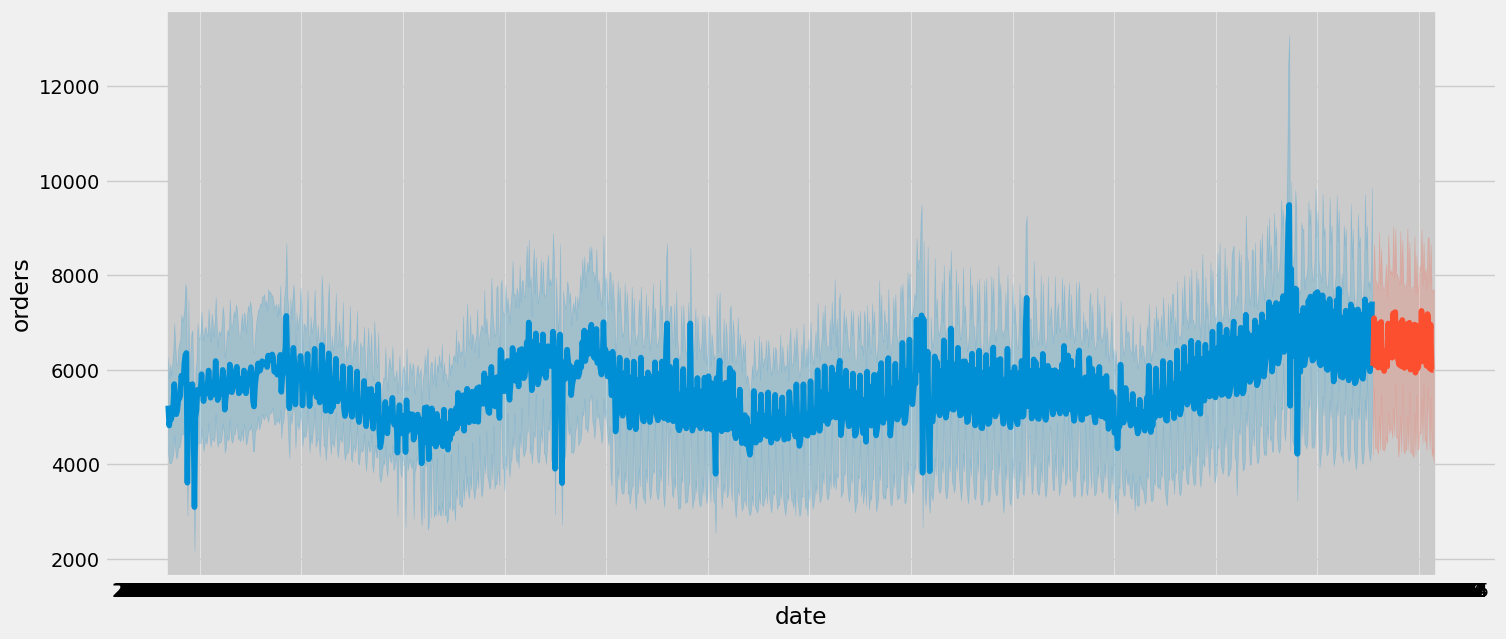

In [422]:
plt.figure(figsize=(16 , 7))
sns.lineplot(x=train_date, y=train.orders)
sns.lineplot(x=test_date, y= y_predict)
plt.show()

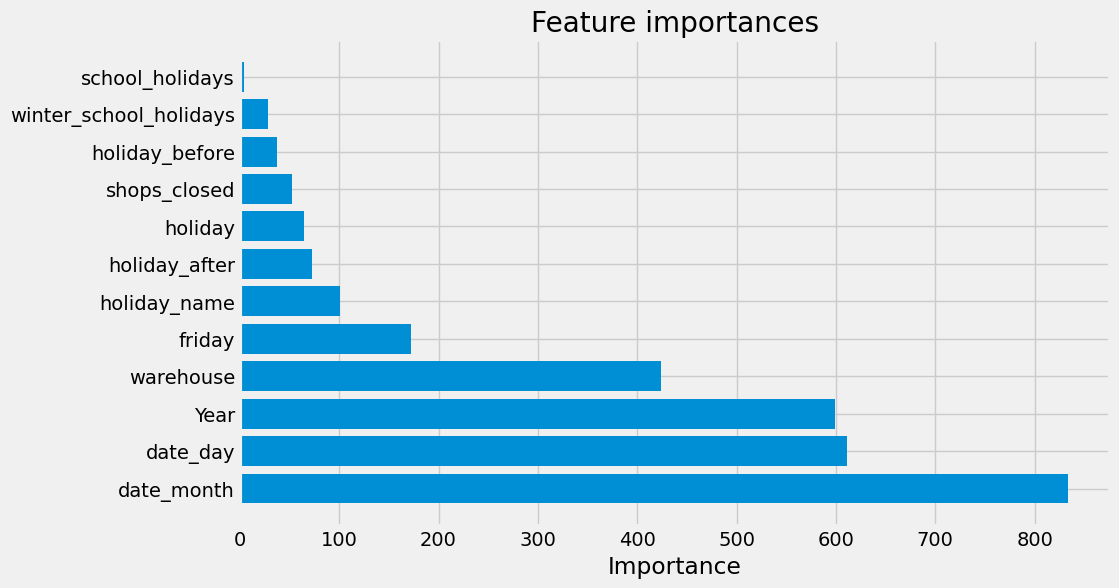

In [423]:
importances = model.feature_importances_

feature_names = train.drop(columns='orders').columns
indices = np.argsort(importances)[::-1]

feature_names = feature_names[indices]
importances = importances[indices]

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.barh(range(len(feature_names)), importances, align="center")
plt.yticks(range(len(feature_names)), feature_names)
plt.xlabel("Importance")
plt.show()

In [424]:
train.columns

Index(['warehouse', 'orders', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'date_day', 'date_month',
       'Year', 'friday', 'holiday_before', 'holiday_after'],
      dtype='object')

#check the dates of the test and the train 
#the publich leaderboard is not 30% first of the data and not the last 30% of the data. 
#read the book and finish the course 
#try the same methods here in the foreast one you build.